## Predict atherosclerosis for patients with SLE

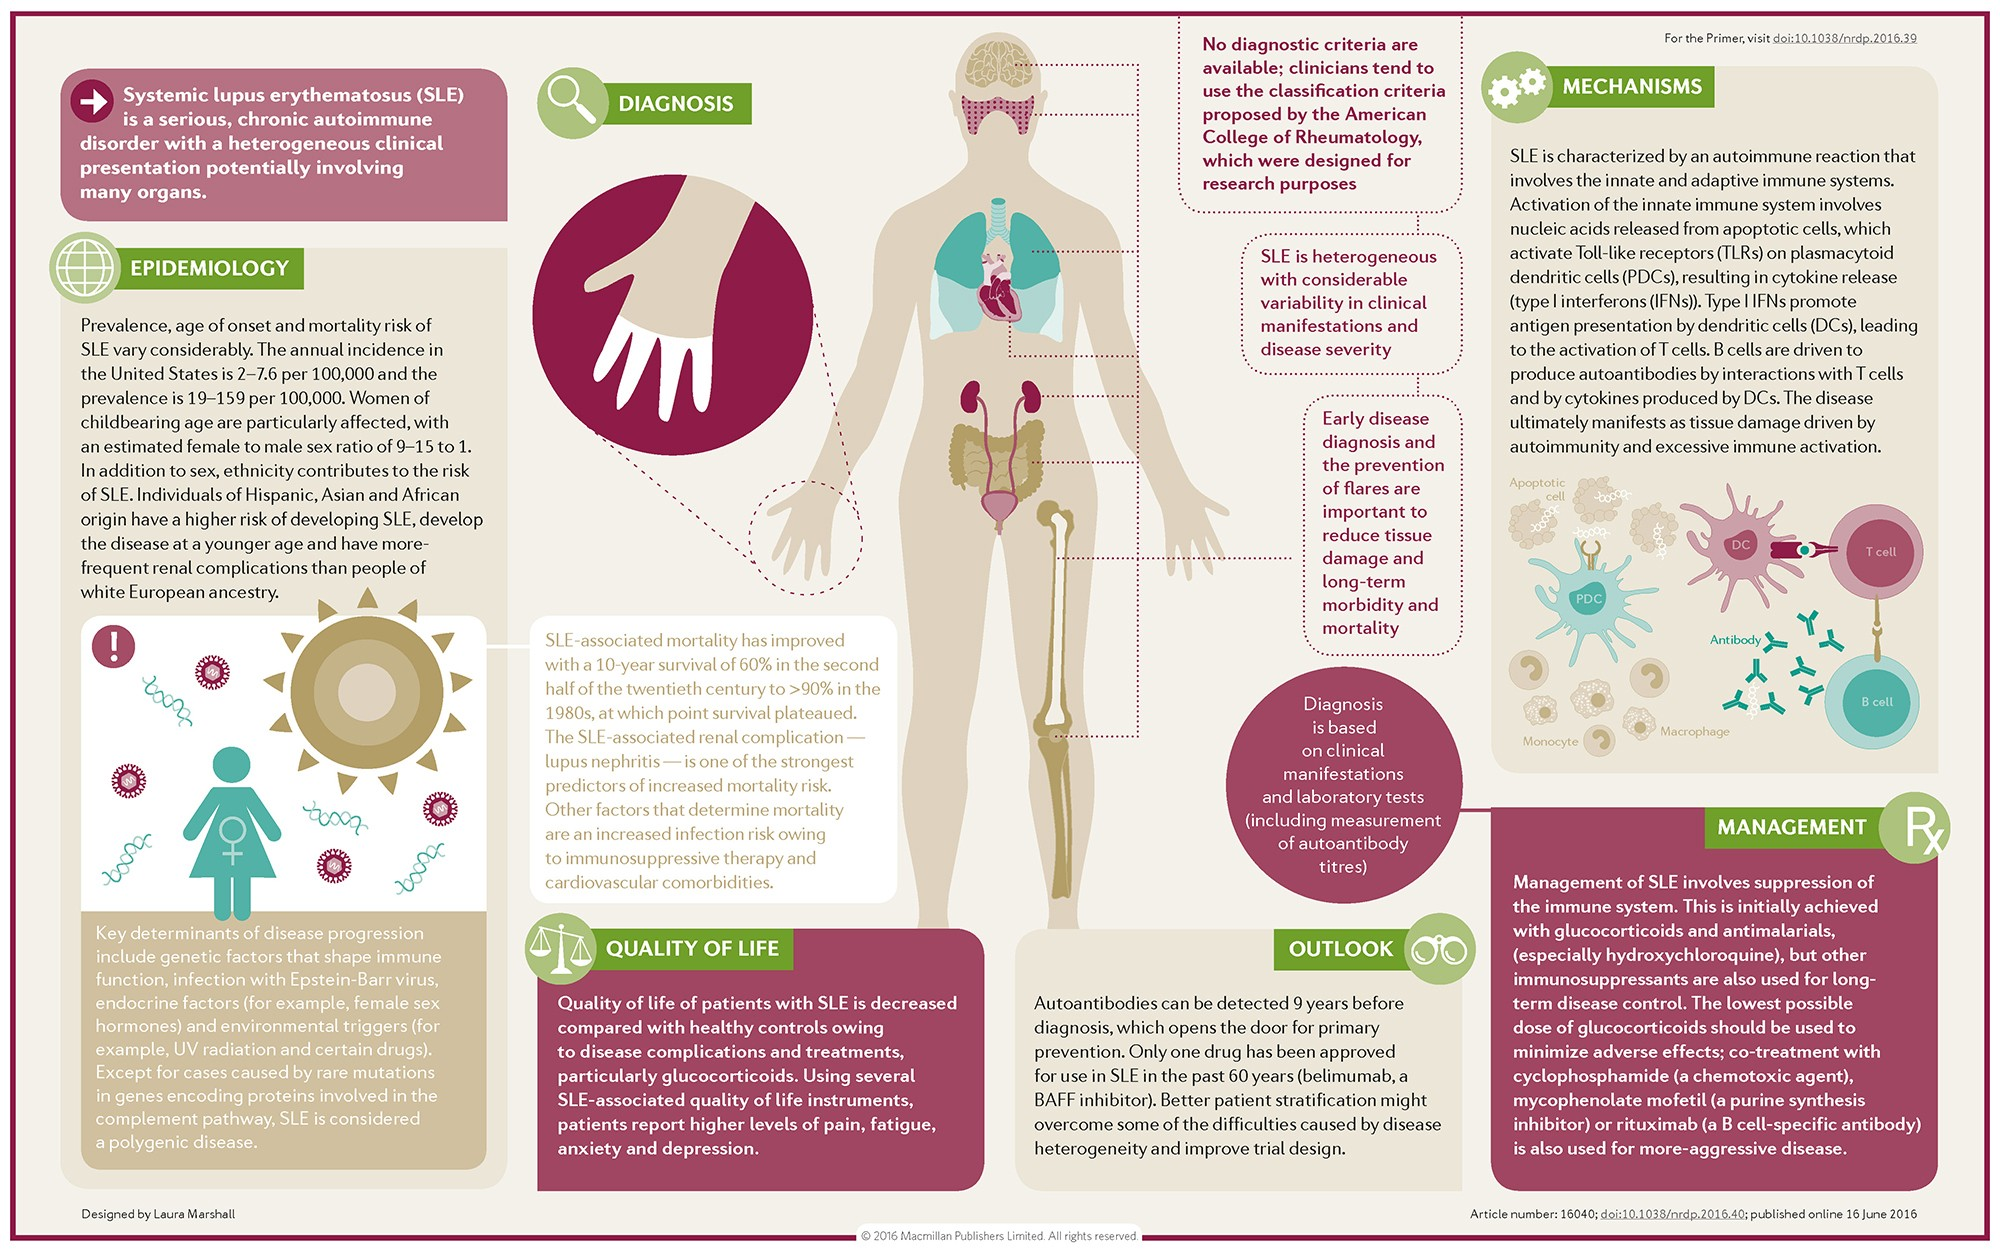

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier                             
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV

In [2]:
PATH = r'.'
SEED = 42

In [3]:
data = pd.read_excel(PATH+"/"+"SLE_transfor.xlsx")
data = data.drop(["Unnamed: 0", "Sample_id"], axis=1)
data

c:\users\pfft\miniconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Phenotype   AcAce     Ace    Ala     Alb  ApoA1   ApoB  ApoB.ApoA1  \
0          HC  0.0507  0.0484  0.399  0.0978   1.78  0.634       0.357   
1          HC  0.0373  0.1200  0.430  0.0892   1.64  0.655       0.399   
2          HC  0.0183  0.0346  0.478  0.0960   1.83  0.925       0.505   
3          HC  0.0478  0.0471  0.376  0.0957   1.71  0.755       0.440   
4          HC  0.0242  0.0419  0.428  0.0849   1.55  0.681       0.438   
..        ...     ...     ...    ...     ...    ...    ...         ...   
114     SLE-P  0.0462  0.0758  0.502  0.0731   1.12  0.776       0.693   
115     SLE-P  0.0316  0.0921  0.461  0.0857   1.10  0.928       0.844   
116     SLE-P  0.0250  0.0708  0.443  0.0846   1.32  0.956       0.723   
117     SLE-P  0.0417  0.0636  0.333  0.0792   1.03  0.838       0.813   
118     SLE-P  0.0660  0.0799  0.302  0.0844   0.82  0.841       1.030   

     bOHBut     Cit  ...  XXL.VLDL.CE  XXL.VLDL.CE_.  XXL.VLDL.FC  \
0    0.2100  0.1190  ...     0.000000           0.00     0.000000   
1    0.0874  0.0980  ...     0.001270           8.43     0.000838   
2    0.0675  0.1150  ...     0.003390           6.82     0.003570   
3    0.1160  0.0906  ...     0.001290          16.90     0.000145   
4    0.0804  0.0804  ...     0.000835           8.13     0.000541   
..      ...     ...  ...          ...            ...          ...   
114  0.1220  0.0721  ...     0.004230          12.30     0.002430   
115  0.0991  0.0538  ...     0.007870          15.10     0.003720   
116  0.1230  0.0613  ...     0.005410          17.00     0.002460   
117  0.1290  0.0586  ...     0.004880          17.90     0.002020   
118  0.1670  0.0367  ...     0.008760          10.10     0.006400   

     XXL.VLDL.FC_.  XXL.VLDL.L    XXL.VLDL.P  XXL.VLDL.PL  XXL.VLDL.PL_.  \
0             0.00     0.00000  0.000000e+00     0.000000           0.00   
1             5.57     0.01510  7.180000e-11     0.001560          10.40   
2             7.18     0.04980  2.350000e-10     0.006340          12.70   
3             1.91     0.00762  3.660000e-11     0.000448           5.87   
4             5.27     0.01030  4.920000e-11     0.001030           9.99   
..             ...         ...           ...          ...            ...   
114           7.08     0.03430  1.600000e-07     0.003870          11.30   
115           7.14     0.05210  2.410000e-07     0.005600          10.80   
116           7.70     0.03190  1.460000e-07     0.003510          11.00   
117           7.38     0.02730  1.260000e-07     0.002210           8.08   
118           7.38     0.08670  4.060000e-07     0.009910          11.40   

     XXL.VLDL.TG  XXL.VLDL.TG_.  
0        0.00000            0.0  
1        0.01140           75.6  
2        0.03650           73.3  
3        0.00574           75.4  
4        0.00787           76.6  
..           ...            ...  
114      0.02370           69.3  
115      0.03490           67.0  
116      0.02050           64.3  
117      0.01820           66.7  
118      0.06160           71.1  

[119 rows x 228 columns]

### EDA

<AxesSubplot:>

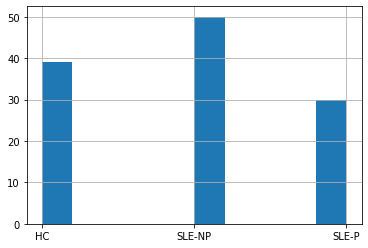

In [5]:
# Class destribution
data.Phenotype.hist()

**Correlation matrix**

Text(0.5, 1.0, 'SLE-P')

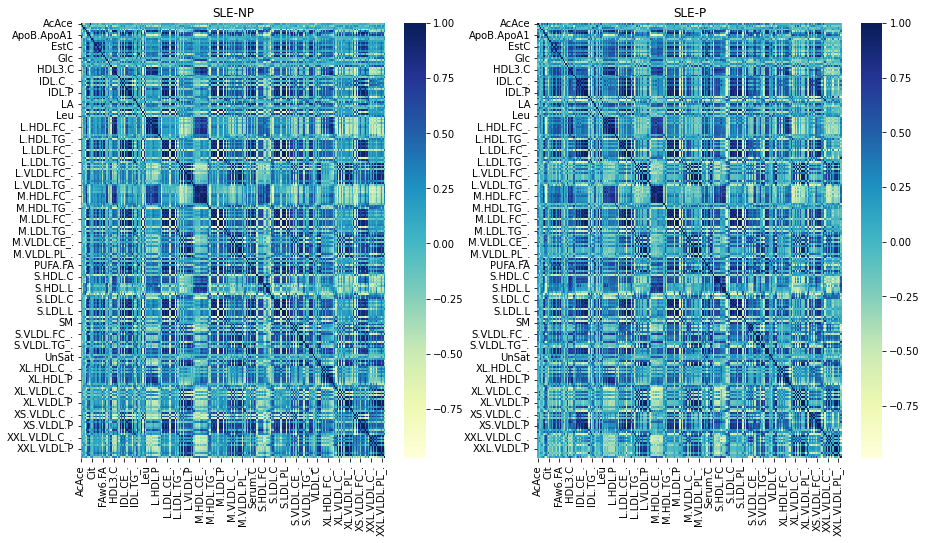

In [12]:
plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
sns.heatmap(data.query('Phenotype == "SLE-NP"').corr(), cmap="YlGnBu")
plt.title("SLE-NP")
# test
plt.subplot(1, 2, 2)
sns.heatmap(data.query('Phenotype == "SLE-P"').corr(), cmap="YlGnBu")
plt.title("SLE-P")

Text(0.5, 1.0, 'SLE')

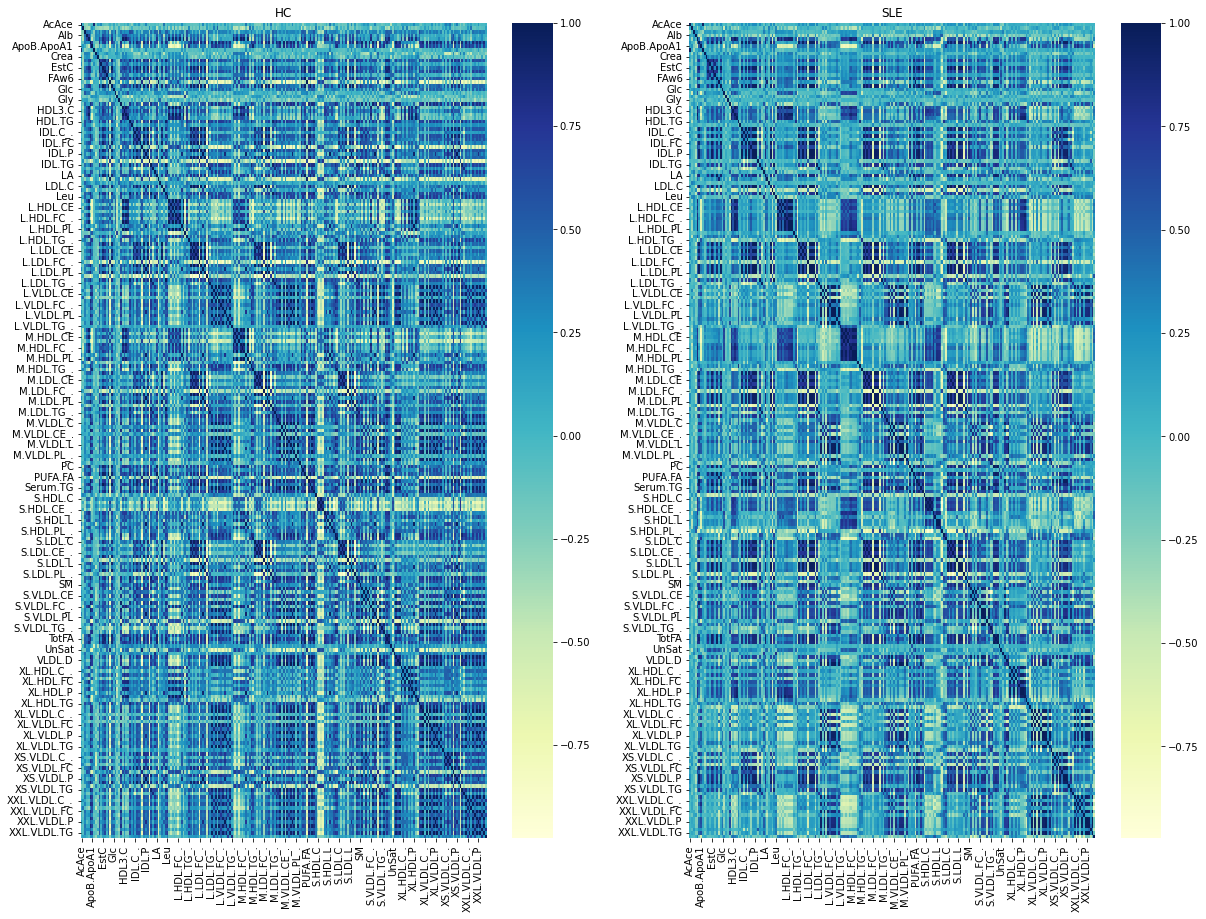

In [13]:
plt.figure(figsize=(20,15))
# train
plt.subplot(1, 2, 1)
sns.heatmap(data.query('Phenotype == "HC"').corr(), cmap="YlGnBu")
plt.title("HC")
# test
plt.subplot(1, 2, 2)
sns.heatmap(data.query('Phenotype == "SLE-P" | Phenotype == "SLE-NP"').corr(), cmap="YlGnBu")
plt.title("SLE")

### Choose SLE samples

In [4]:
data = data.query('Phenotype == "SLE-P" | Phenotype == "SLE-NP"')

In [5]:
X = data.drop("Phenotype", axis=1)
y = data["Phenotype"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, stratify=y, train_size=0.75)
X_train.head()

AcAce     Ace    Ala     Alb  ApoA1   ApoB  ApoB.ApoA1  bOHBut     Cit  \
94   0.0204  0.0348  0.413  0.0929  1.490  0.700       0.470  0.0899  0.0888   
51   0.0232  0.0795  0.447  0.0924  0.495  0.495       0.999  0.1050  0.0695   
44   0.0371  0.0991  0.442  0.0864  1.220  0.572       0.470  0.0859  0.0869   
66   0.0414  0.0762  0.401  0.0891  1.070  0.617       0.575  0.1100  0.0579   
111  0.0417  0.0662  0.376  0.0794  1.090  1.010       0.925  0.1090  0.0424   

       Crea  ...  XXL.VLDL.CE  XXL.VLDL.CE_.  XXL.VLDL.FC  XXL.VLDL.FC_.  \
94   0.0328  ...     0.000018          0.257     0.000639           9.06   
51   0.0493  ...     0.011100         29.200     0.006460          17.00   
44   0.0495  ...     0.001560         13.700     0.000585           5.11   
66   0.0338  ...     0.002670         17.200     0.001150           7.41   
111  0.0573  ...     0.008130         14.900     0.004190           7.67   

     XXL.VLDL.L    XXL.VLDL.P  XXL.VLDL.PL  XXL.VLDL.PL_.  XXL.VLDL.TG  \
94      0.00706  3.360000e-08     0.000905          12.80      0.00550   
51      0.03810  1.600000e-07     0.001130           2.96      0.01940   
44      0.01150  5.420000e-08     0.000922           8.05      0.00838   
66      0.01550  7.180000e-08     0.001140           7.36      0.01060   
111     0.05460  2.520000e-07     0.005940          10.90      0.03640   

     XXL.VLDL.TG_.  
94            77.9  
51            50.9  
44            73.2  
66            68.0  
111           66.6  

[5 rows x 227 columns]

In [21]:
X_train.shape, X_test.shape # Train/test size

((60, 227), (20, 227))

### Normalization

In [6]:
stdscl = StandardScaler()
X_train = stdscl.fit_transform(X_train)
X_test = stdscl.transform(X_test)

<AxesSubplot:xlabel='Phenotype', ylabel='Count'>

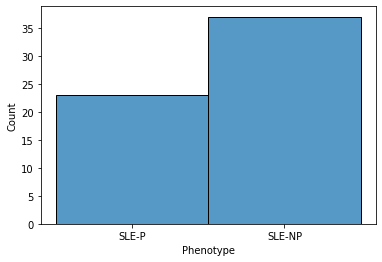

In [24]:
sns.histplot(y_train)

<AxesSubplot:xlabel='Phenotype', ylabel='Count'>

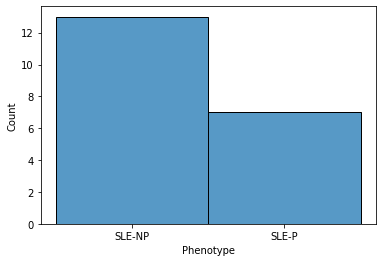

In [25]:
sns.histplot(y_test)

### Target transformation

In [7]:
y_train = list(map(lambda x: 1 if x == 'SLE-P' else 0, y_train.values))
y_test = list(map(lambda x: 1 if x == 'SLE-P' else 0, y_test.values))

## ML

Primary selection of models

In [31]:
%%time
# 
dt = DecisionTreeClassifier(random_state=SEED)
rf = RandomForestClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', random_state=SEED)

for model in [dt, rf, knn, lgbm, lr]: 
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.36666666666666664
RandomForestClassifier: 0.43650793650793657
KNeighborsClassifier: 0.4523809523809524
LGBMClassifier: 0.4511544011544012
LogisticRegression: 0.39878787878787875
Wall time: 1.78 s


In [33]:
# DecisionTree
param_grid = [{'max_features':[10, 40, 80],
              'max_depth': [10, 20, 40],
              'min_samples_leaf':[5, 10, 20]}
             ]
tree = DecisionTreeClassifier(random_state=SEED)
grid_search = GridSearchCV(tree, param_grid,
                          cv=5, scoring='f1',
                          return_train_score=True)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"],
                             cvres["params"]):
    print(mean_score, params)

DecisionTreeClassifier(max_depth=10, max_features=80, min_samples_leaf=20,
                       random_state=42)
0.4116161616161616 {'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 5}
0.3833333333333333 {'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 10}
0.5 {'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 20}
0.5097402597402597 {'max_depth': 10, 'max_features': 40, 'min_samples_leaf': 5}
0.4325974025974026 {'max_depth': 10, 'max_features': 40, 'min_samples_leaf': 10}
0.5466666666666666 {'max_depth': 10, 'max_features': 40, 'min_samples_leaf': 20}
0.3031746031746032 {'max_depth': 10, 'max_features': 80, 'min_samples_leaf': 5}
0.47714285714285715 {'max_depth': 10, 'max_features': 80, 'min_samples_leaf': 10}
0.5478787878787879 {'max_depth': 10, 'max_features': 80, 'min_samples_leaf': 20}
0.4116161616161616 {'max_depth': 20, 'max_features': 10, 'min_samples_leaf': 5}
0.3833333333333333 {'max_depth': 20, 'max_features': 10, 'min_samples_leaf': 10}
0.5 {'max_de

In [34]:
# KNN
param_grid = [{'n_neighbors':[5, 10, 20],
              'weights': ['uniform', "distance"],
              'p':[1, 2]}
             ]
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid,
                          cv=5, scoring='f1',
                          return_train_score=True)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"],
                             cvres["params"]):
    print(mean_score, params)

KNeighborsClassifier(n_neighbors=10, weights='distance')
0.4057142857142858 {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
0.4057142857142858 {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
0.4523809523809524 {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
0.4523809523809524 {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
0.3928571428571429 {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}
0.4103174603174603 {'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
0.41904761904761906 {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}
0.48571428571428565 {'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
0.1142857142857143 {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'}
0.3142857142857143 {'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
0.13333333333333336 {'n_neighbors': 20, 'p': 2, 'weights': 'uniform'}
0.3038095238095238 {'n_neighbors': 20, 'p': 2, 'weights': 'distance'}


In [35]:
# LogisticRegression
param_grid = [{'penalty':['l1', 'l2'],
              'solver':['lbfgs', 'liblinear']}
             ]
lr = LogisticRegression(random_state=SEED)
grid_search = GridSearchCV(lr, param_grid,
                          cv=5, scoring='f1',
                          return_train_score=True)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"],
                             cvres["params"]):
    print(mean_score, params)

LogisticRegression(penalty='l1', random_state=42, solver='liblinear')
nan {'penalty': 'l1', 'solver': 'lbfgs'}
0.47212121212121216 {'penalty': 'l1', 'solver': 'liblinear'}
0.4522222222222222 {'penalty': 'l2', 'solver': 'lbfgs'}
0.39878787878787875 {'penalty': 'l2', 'solver': 'liblinear'}


c:\users\pfft\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\pfft\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\pfft\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\users\pfft\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueE

In [36]:
# RandomForest
param_grid = [{'n_estimators':[100,300,500],
              'max_features':[10, 40, 80],
              'max_depth': [10, 20, 40]}
             ]
forest = RandomForestClassifier(random_state=SEED)
grid_search = GridSearchCV(forest, param_grid,
                          cv=5, scoring='f1',
                          return_train_score=True)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"],
                             cvres["params"]):
    print(mean_score, params)

RandomForestClassifier(max_depth=10, max_features=80, n_estimators=300,
                       random_state=42)
0.4174603174603175 {'max_depth': 10, 'max_features': 10, 'n_estimators': 100}
0.4436507936507937 {'max_depth': 10, 'max_features': 10, 'n_estimators': 300}
0.4436507936507937 {'max_depth': 10, 'max_features': 10, 'n_estimators': 500}
0.451948051948052 {'max_depth': 10, 'max_features': 40, 'n_estimators': 100}
0.47365079365079366 {'max_depth': 10, 'max_features': 40, 'n_estimators': 300}
0.4825396825396825 {'max_depth': 10, 'max_features': 40, 'n_estimators': 500}
0.4014285714285714 {'max_depth': 10, 'max_features': 80, 'n_estimators': 100}
0.4993650793650793 {'max_depth': 10, 'max_features': 80, 'n_estimators': 300}
0.4593650793650793 {'max_depth': 10, 'max_features': 80, 'n_estimators': 500}
0.4174603174603175 {'max_depth': 20, 'max_features': 10, 'n_estimators': 100}
0.4436507936507937 {'max_depth': 20, 'max_features': 10, 'n_estimators': 300}
0.4436507936507937 {'max_depth

### Use custom function to validate models

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def get_metrics(y_test, y_pred):
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("Precision: ", precision_score(y_test, y_pred))
    print("Recall: ", recall_score(y_test, y_pred))
    print("F1: ", f1_score(y_test, y_pred))

In [38]:
best_tree = DecisionTreeClassifier(max_depth=10, max_features=80, min_samples_leaf=20,
                       random_state=42)
best_tree.fit(X_train, y_train)
y_pred = best_tree.predict(X_test)
get_metrics(y_test, y_pred)

Accuracy:  0.65
Precision:  0.5
Recall:  0.8571428571428571
F1:  0.631578947368421


In [39]:
knn_scaled = KNeighborsClassifier(n_neighbors=10, weights='distance')
knn_scaled.fit(X_train, y_train)
y_pred = knn_scaled.predict(X_test)
get_metrics(y_test, y_pred)

Accuracy:  0.65
Precision:  0.5
Recall:  0.2857142857142857
F1:  0.36363636363636365


In [40]:
lr = LogisticRegression(penalty='l1', random_state=42, solver='liblinear')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
get_metrics(y_test, y_pred)

Accuracy:  0.8
Precision:  0.6363636363636364
Recall:  1.0
F1:  0.7777777777777778


In [41]:
rf = RandomForestClassifier(max_depth=10, max_features=80, n_estimators=300,
                       random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
get_metrics(y_test, y_pred)

Accuracy:  0.6
Precision:  0.42857142857142855
Recall:  0.42857142857142855
F1:  0.42857142857142855


## Reduction dataset

Choose keto/aminoacids to predict plug

In [4]:
data = data[['Phenotype','AcAce','Ace','Ala','Alb',
  'bOHBut','Cit','Crea',
  'Glc','Gln','Glol','Gly',
  'His','Ile','Lac',
  'Leu','Phe','Tyr','Val']]
data = data.query('Phenotype == "SLE-P" | Phenotype == "SLE-NP"')

In [5]:
X = data.drop("Phenotype", axis=1)
y = data["Phenotype"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, stratify=y, train_size=0.75)
X_train.head()
X_train.shape, X_test.shape

((60, 18), (20, 18))

In [6]:
stdscl = StandardScaler()
X_train = stdscl.fit_transform(X_train)
X_test = stdscl.transform(X_test)

In [7]:
y_train = list(map(lambda x: 1 if x == 'SLE-P' else 0, y_train.values))
y_test = list(map(lambda x: 1 if x == 'SLE-P' else 0, y_test.values))

In [8]:
%%time
# 
dt = DecisionTreeClassifier(random_state=SEED)
rf = RandomForestClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', random_state=SEED)

for model in [dt, rf, knn, lgbm, lr]: 
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.5533333333333333
RandomForestClassifier: 0.3476190476190476
KNeighborsClassifier: 0.3
LGBMClassifier: 0.33766233766233766
LogisticRegression: 0.4731746031746032
Wall time: 2.87 s


In [9]:
# DecisionTree
param_grid = [{'max_features':[5, 10, 15],
              'max_depth': [5, 10, 15],
              'min_samples_leaf':[5, 10, 20]}
             ]
tree = DecisionTreeClassifier(random_state=SEED)
grid_search = GridSearchCV(tree, param_grid,
                          cv=5, scoring='f1',
                          return_train_score=True)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"],
                             cvres["params"]):
    print(mean_score, params)

DecisionTreeClassifier(max_depth=5, max_features=10, min_samples_leaf=20,
                       random_state=42)
0.28606060606060607 {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 5}
0.2958730158730159 {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 10}
0.2942857142857143 {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 20}
0.4682539682539682 {'max_depth': 5, 'max_features': 10, 'min_samples_leaf': 5}
0.5095238095238096 {'max_depth': 5, 'max_features': 10, 'min_samples_leaf': 10}
0.6545454545454545 {'max_depth': 5, 'max_features': 10, 'min_samples_leaf': 20}
0.4800000000000001 {'max_depth': 5, 'max_features': 15, 'min_samples_leaf': 5}
0.43607503607503617 {'max_depth': 5, 'max_features': 15, 'min_samples_leaf': 10}
0.6545454545454545 {'max_depth': 5, 'max_features': 15, 'min_samples_leaf': 20}
0.28606060606060607 {'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 5}
0.2958730158730159 {'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 10}
0.29428571

In [10]:
# KNN
param_grid = [{'n_neighbors':[5, 10, 20],
              'weights': ['uniform', "distance"],
              'p':[1, 2]}
             ]
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid,
                          cv=5, scoring='f1',
                          return_train_score=True)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"],
                             cvres["params"]):
    print(mean_score, params)

KNeighborsClassifier()
0.2666666666666667 {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
0.2666666666666667 {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
0.3 {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
0.3 {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
0.2038095238095238 {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}
0.24761904761904763 {'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
0.22857142857142856 {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}
0.2333333333333333 {'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
0.06666666666666668 {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'}
0.29523809523809524 {'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
0.06666666666666668 {'n_neighbors': 20, 'p': 2, 'weights': 'uniform'}
0.2666666666666667 {'n_neighbors': 20, 'p': 2, 'weights': 'distance'}


In [11]:
# LogisticRegression
param_grid = [{'penalty':['l1', 'l2'],
              'solver':['lbfgs', 'liblinear']}
             ]
lr = LogisticRegression(random_state=SEED)
grid_search = GridSearchCV(lr, param_grid,
                          cv=5, scoring='f1',
                          return_train_score=True)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"],
                             cvres["params"]):
    print(mean_score, params)

LogisticRegression(random_state=42, solver='liblinear')
nan {'penalty': 'l1', 'solver': 'lbfgs'}
0.4374603174603175 {'penalty': 'l1', 'solver': 'liblinear'}
0.43984126984126987 {'penalty': 'l2', 'solver': 'lbfgs'}
0.4731746031746032 {'penalty': 'l2', 'solver': 'liblinear'}


c:\users\pfft\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\pfft\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\pfft\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\users\pfft\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueE

In [12]:
# RandomForest
param_grid = [{'n_estimators':[100,300,500],
              'max_features':[5, 10, 15],
              'max_depth': [5, 10, 15]}
             ]
forest = RandomForestClassifier(random_state=SEED)
grid_search = GridSearchCV(forest, param_grid,
                          cv=5, scoring='f1',
                          return_train_score=True)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"],
                             cvres["params"]):
    print(mean_score, params)

RandomForestClassifier(max_depth=10, max_features=10, n_estimators=500,
                       random_state=42)
0.26623376623376627 {'max_depth': 5, 'max_features': 5, 'n_estimators': 100}
0.2904761904761905 {'max_depth': 5, 'max_features': 5, 'n_estimators': 300}
0.2904761904761905 {'max_depth': 5, 'max_features': 5, 'n_estimators': 500}
0.36623376623376624 {'max_depth': 5, 'max_features': 10, 'n_estimators': 100}
0.3 {'max_depth': 5, 'max_features': 10, 'n_estimators': 300}
0.4 {'max_depth': 5, 'max_features': 10, 'n_estimators': 500}
0.3936507936507937 {'max_depth': 5, 'max_features': 15, 'n_estimators': 100}
0.3571428571428571 {'max_depth': 5, 'max_features': 15, 'n_estimators': 300}
0.3904761904761904 {'max_depth': 5, 'max_features': 15, 'n_estimators': 500}
0.26623376623376627 {'max_depth': 10, 'max_features': 5, 'n_estimators': 100}
0.2904761904761905 {'max_depth': 10, 'max_features': 5, 'n_estimators': 300}
0.3571428571428571 {'max_depth': 10, 'max_features': 5, 'n_estimators':

In [16]:
best_tree = DecisionTreeClassifier(max_depth=5, max_features=10, min_samples_leaf=20,
                       random_state=42)
best_tree.fit(X_train, y_train)
y_pred = best_tree.predict(X_test)
get_metrics(y_test, y_pred)

Accuracy:  0.65
Precision:  0.5
Recall:  0.8571428571428571
F1:  0.631578947368421


In [17]:
knn_scaled = KNeighborsClassifier()
knn_scaled.fit(X_train, y_train)
y_pred = knn_scaled.predict(X_test)
get_metrics(y_test, y_pred)

Accuracy:  0.6
Precision:  0.4444444444444444
Recall:  0.5714285714285714
F1:  0.5


In [18]:
lr = LogisticRegression(random_state=42, solver='liblinear')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
get_metrics(y_test, y_pred)

Accuracy:  0.6
Precision:  0.4444444444444444
Recall:  0.5714285714285714
F1:  0.5


In [19]:
rf = RandomForestClassifier(max_depth=10, max_features=10, n_estimators=500,
                       random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
get_metrics(y_test, y_pred)

Accuracy:  0.55
Precision:  0.4
Recall:  0.5714285714285714
F1:  0.47058823529411764


### Feature engineering

In [20]:
X["BCAA"] = (X.Ile + X.Val + X.Leu)/(X.Ile + X.Val + X.Leu + X.Ala + X.Gln + X.Gly + X.His + X.Phe + X.Tyr)
#
X["Ket_AA"] = (X.Ace + X.AcAce + X.bOHBut)/(X.Ile + X.Val + X.Leu + X.Ala + X.Gln + X.Gly + X.His + X.Phe + X.Tyr)
#
X["Alb_proteolysis"] = (X.Ile + X.Val + X.Leu + X.Ala + X.Gln + X.Gly + X.His + X.Phe + X.Tyr)/X.Alb
#
X["Anaerobic_glyc"] = X.Lac/X.Glc
X["Activation_substrates"] = X.Glc/X.Gln
X["Gly_Lip"] = X.Glc/X.Glol
X["Gly_TCA"] = X.Glc/X.Cit

In [21]:
X.columns

Index(['AcAce', 'Ace', 'Ala', 'Alb', 'bOHBut', 'Cit', 'Crea', 'Glc', 'Gln',
       'Glol', 'Gly', 'His', 'Ile', 'Lac', 'Leu', 'Phe', 'Tyr', 'Val', 'BCAA',
       'Ket_AA', 'Alb_proteolysis', 'Anaerobic_glyc', 'Activation_substrates',
       'Gly_Lip', 'Gly_TCA'],
      dtype='object')

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, stratify=y, train_size=0.75)
#X_train.head()
X_train.shape, X_test.shape
stdscl = StandardScaler()
X_train = stdscl.fit_transform(X_train)
X_test = stdscl.transform(X_test)
y_train = list(map(lambda x: 1 if x == 'SLE-P' else 0, y_train.values))
y_test = list(map(lambda x: 1 if x == 'SLE-P' else 0, y_test.values))

In [23]:
# DecisionTree
param_grid = [{'max_features':[5, 10, 20],
              'max_depth': [5, 10, 15],
              'min_samples_leaf':[5, 10, 20]}
             ]
tree = DecisionTreeClassifier(random_state=SEED)
grid_search = GridSearchCV(tree, param_grid,
                          cv=5, scoring='f1',
                          return_train_score=True)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"],
                             cvres["params"]):
    print(mean_score, params)

DecisionTreeClassifier(max_depth=5, max_features=20, min_samples_leaf=20,
                       random_state=42)
0.3822222222222223 {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 5}
0.4015873015873016 {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 10}
0.3742857142857144 {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 20}
0.2890909090909091 {'max_depth': 5, 'max_features': 10, 'min_samples_leaf': 5}
0.41004329004329004 {'max_depth': 5, 'max_features': 10, 'min_samples_leaf': 10}
0.3666666666666667 {'max_depth': 5, 'max_features': 10, 'min_samples_leaf': 20}
0.531904761904762 {'max_depth': 5, 'max_features': 20, 'min_samples_leaf': 5}
0.4146464646464646 {'max_depth': 5, 'max_features': 20, 'min_samples_leaf': 10}
0.6545454545454545 {'max_depth': 5, 'max_features': 20, 'min_samples_leaf': 20}
0.3822222222222223 {'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 5}
0.4015873015873016 {'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 10}
0.37428571428

In [24]:
# KNN
param_grid = [{'n_neighbors':[5, 10, 20],
              'weights': ['uniform', "distance"],
              'p':[1, 2]}
             ]
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid,
                          cv=5, scoring='f1',
                          return_train_score=True)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"],
                             cvres["params"]):
    print(mean_score, params)

KNeighborsClassifier()
0.24945054945054945 {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
0.24945054945054945 {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
0.27714285714285714 {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
0.27714285714285714 {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
0.19047619047619047 {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}
0.27380952380952384 {'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
0.2 {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}
0.2571428571428572 {'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
0.0 {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'}
0.2 {'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
0.13333333333333333 {'n_neighbors': 20, 'p': 2, 'weights': 'uniform'}
0.2 {'n_neighbors': 20, 'p': 2, 'weights': 'distance'}


In [25]:
# LogisticRegression
param_grid = [{'penalty':['l1', 'l2'],
              'solver':['lbfgs', 'liblinear']}
             ]
lr = LogisticRegression(random_state=SEED)
grid_search = GridSearchCV(lr, param_grid,
                          cv=5, scoring='f1',
                          return_train_score=True)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"],
                             cvres["params"]):
    print(mean_score, params)

LogisticRegression(random_state=42, solver='liblinear')
nan {'penalty': 'l1', 'solver': 'lbfgs'}
0.4231746031746032 {'penalty': 'l1', 'solver': 'liblinear'}
0.3898412698412699 {'penalty': 'l2', 'solver': 'lbfgs'}
0.43984126984126987 {'penalty': 'l2', 'solver': 'liblinear'}


c:\users\pfft\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\pfft\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\pfft\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\users\pfft\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueE

In [26]:
# RandomForest
param_grid = [{'n_estimators':[100,300,500],
              'max_features':[5, 10, 20],
              'max_depth': [5, 10, 15]}
             ]
forest = RandomForestClassifier(random_state=SEED)
grid_search = GridSearchCV(forest, param_grid,
                          cv=5, scoring='f1',
                          return_train_score=True)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"],
                             cvres["params"]):
    print(mean_score, params)

RandomForestClassifier(max_depth=5, max_features=5, random_state=42)
0.46190476190476193 {'max_depth': 5, 'max_features': 5, 'n_estimators': 100}
0.46190476190476193 {'max_depth': 5, 'max_features': 5, 'n_estimators': 300}
0.3948051948051948 {'max_depth': 5, 'max_features': 5, 'n_estimators': 500}
0.41904761904761906 {'max_depth': 5, 'max_features': 10, 'n_estimators': 100}
0.46190476190476193 {'max_depth': 5, 'max_features': 10, 'n_estimators': 300}
0.46190476190476193 {'max_depth': 5, 'max_features': 10, 'n_estimators': 500}
0.4253968253968254 {'max_depth': 5, 'max_features': 20, 'n_estimators': 100}
0.38888888888888895 {'max_depth': 5, 'max_features': 20, 'n_estimators': 300}
0.40476190476190477 {'max_depth': 5, 'max_features': 20, 'n_estimators': 500}
0.44761904761904764 {'max_depth': 10, 'max_features': 5, 'n_estimators': 100}
0.46190476190476193 {'max_depth': 10, 'max_features': 5, 'n_estimators': 300}
0.38051948051948054 {'max_depth': 10, 'max_features': 5, 'n_estimators': 500}


In [27]:
best_tree = DecisionTreeClassifier(max_depth=5, max_features=20, min_samples_leaf=20,
                       random_state=42)
best_tree.fit(X_train, y_train)
y_pred = best_tree.predict(X_test)
get_metrics(y_test, y_pred)


Accuracy:  0.65
Precision:  0.5
Recall:  0.8571428571428571
F1:  0.631578947368421


In [28]:
knn_scaled = KNeighborsClassifier()
knn_scaled.fit(X_train, y_train)
y_pred = knn_scaled.predict(X_test)
get_metrics(y_test, y_pred)

Accuracy:  0.65
Precision:  0.5
Recall:  0.5714285714285714
F1:  0.5333333333333333


In [29]:
lr = LogisticRegression(random_state=42, solver='liblinear')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
get_metrics(y_test, y_pred)

Accuracy:  0.5
Precision:  0.3333333333333333
Recall:  0.42857142857142855
F1:  0.375


In [30]:
rf = RandomForestClassifier(max_depth=5, max_features=5, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
get_metrics(y_test, y_pred)

Accuracy:  0.5
Precision:  0.2857142857142857
Recall:  0.2857142857142857
F1:  0.2857142857142857


### Save the best model for all data

In [8]:
data = pd.read_excel(PATH+"/"+"SLE_transfor.xlsx")
data = data.drop(["Unnamed: 0", "Sample_id"], axis=1)
data = data.query('Phenotype == "SLE-P" | Phenotype == "SLE-NP"')
#
X = data.drop("Phenotype", axis=1)
y = data["Phenotype"]
#
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, stratify=y, train_size=0.75)
#
stdscl = StandardScaler()
X_train = stdscl.fit_transform(X_train)
X_test = stdscl.transform(X_test)
#
y_train = list(map(lambda x: 1 if x == 'SLE-P' else 0, y_train.values))
y_test = list(map(lambda x: 1 if x == 'SLE-P' else 0, y_test.values))

c:\users\pfft\miniconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [12]:
lr = LogisticRegression(penalty='l1', random_state=42, solver='liblinear')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
get_metrics(y_test, y_pred)

Accuracy:  0.8
Precision:  0.6363636363636364
Recall:  1.0
F1:  0.7777777777777778


In [13]:
import joblib
#joblib.dump(lr, "best_model_all_fech_lr_1.pkl")

### Train other model to improve accuracy
Make function to find the best model automaticly

In [11]:
def get_accurat_report(X_train, y_train, X_test, y_test, metric="accuracy", tree_order=2.5, SEED=42):
    dt = DecisionTreeClassifier(random_state=SEED)
    rf = RandomForestClassifier(random_state=SEED)
    knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
    lgbm = lightgbm.LGBMClassifier(random_state=SEED)
    lr = LogisticRegression(solver='liblinear', random_state=SEED)
    
    print("COMMON PERFORMANCE: ", end='\n')
    
    for model in [dt, rf, knn, lgbm, lr]: 
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring=metric)
        print(f"{model.__class__.__name__}: {scores.mean()}")
    #
    print()
    print()
    #
    #
    print("TREE TUNE: ", end="\n")
    param_grid = [{'max_features':[round(i*tree_order) for i in [2, 5, 10]],
                  'max_depth': [round(i*tree_order) for i in [2, 5, 10]],
                  'min_samples_leaf':[5, 10, round(X_train.shape[1]*0.5)]}
                 ]
    tree = DecisionTreeClassifier(random_state=SEED)
    grid_search = GridSearchCV(tree, param_grid,
                              cv=5, scoring=metric,
                              return_train_score=True)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_estimator_)
    print(grid_search.best_score_)
    cvres = grid_search.cv_results_
    for mean_score, params in zip(cvres["mean_test_score"],
                                 cvres["params"]):
        print(mean_score, params)
    print()
    #
    #
    print("TREE_VALIDATION: ", end='\n')
    best_tree = DecisionTreeClassifier(max_depth=grid_search.best_params_['max_depth'],
                                  max_features=grid_search.best_params_['max_features'],
                                      min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
                                      random_state=SEED)
    best_tree.fit(X_train, y_train)
    y_pred = best_tree.predict(X_test)
    get_metrics(y_test, y_pred)
    #
    print()
    print()
    #
    # KNN
    print("KNN TUNE: ", end="\n")
    param_grid = [{'n_neighbors':[5, 10, 20],
                  'weights': ['uniform', "distance"],
                  'p':[1, 2]}
                 ]
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(knn, param_grid,
                              cv=5, scoring=metric,
                              return_train_score=True)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_estimator_)
    print(grid_search.best_score_)
    cvres = grid_search.cv_results_
    for mean_score, params in zip(cvres["mean_test_score"],
                                 cvres["params"]):
        print(mean_score, params)
        #
    print()
    print("KNN_VALIDATION: ", end='\n')
    
    knn_scaled = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'],
                                      weights=grid_search.best_params_['weights'],
                                      p=grid_search.best_params_['p'])
    knn_scaled.fit(X_train, y_train)
    y_pred = knn_scaled.predict(X_test)
    get_metrics(y_test, y_pred)
    #
    print()
    print()
    #
    #
    print("LR TUNE: ", end="\n")
    # LogisticRegression
    param_grid = [{'penalty':['l1', 'l2'],
                  'solver':['lbfgs', 'liblinear']}
                 ]
    lr = LogisticRegression(random_state=SEED)
    grid_search = GridSearchCV(lr, param_grid,
                              cv=5, scoring=metric,
                              return_train_score=True)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_estimator_)
    print(grid_search.best_score_)
    cvres = grid_search.cv_results_
    for mean_score, params in zip(cvres["mean_test_score"],
                                 cvres["params"]):
        print(mean_score, params)
    #
    print()
    print("LR_VALIDATION: ", end='\n')
    lr = LogisticRegression(penalty=grid_search.best_params_['penalty'],
                           solver=grid_search.best_params_['solver'],
                           random_state=SEED)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    get_metrics(y_test, y_pred)
    #
    print()
    print()
    #
    #
    print("RF TUNE: ", end="\n")
    # RandomForest
    param_grid = [{'max_features':[round(i*tree_order) for i in [2, 5, 10]],
                  'max_depth': [round(i*tree_order) for i in [2, 5, 10]],
                  'min_samples_leaf':[5, 10, round(X_train.shape[1]*0.5)]}
                 ]
    forest = RandomForestClassifier(random_state=SEED)
    grid_search = GridSearchCV(forest, param_grid,
                              cv=5, scoring=metric,
                              return_train_score=True)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_estimator_)
    print(grid_search.best_score_)
    cvres = grid_search.cv_results_
    for mean_score, params in zip(cvres["mean_test_score"],
                                 cvres["params"]):
        print(mean_score, params)
    print()
    print("RF_VALIDATION: ", end='\n')    
    rf = RandomForestClassifier(max_depth=grid_search.best_params_['max_depth'],
                                  max_features=grid_search.best_params_['max_features'],
                                      min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
                                random_state=SEED)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    get_metrics(y_test, y_pred)

In [41]:
get_accurat_report(X_train, y_train, X_test, y_test, metric="accuracy", SEED=SEED)

COMMON PERFORMANCE: 
DecisionTreeClassifier: 0.5
RandomForestClassifier: 0.6333333333333334
KNeighborsClassifier: 0.7166666666666666
LGBMClassifier: 0.6000000000000001
LogisticRegression: 0.4833333333333333


TREE TUNE: 
DecisionTreeClassifier(max_depth=5, max_features=5, min_samples_leaf=10,
                       random_state=42)
0.65
0.6000000000000001 {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 5}
0.65 {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 10}
0.6166666666666666 {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 114}
0.5 {'max_depth': 5, 'max_features': 12, 'min_samples_leaf': 5}
0.6 {'max_depth': 5, 'max_features': 12, 'min_samples_leaf': 10}
0.6166666666666666 {'max_depth': 5, 'max_features': 12, 'min_samples_leaf': 114}
0.5999999999999999 {'max_depth': 5, 'max_features': 25, 'min_samples_leaf': 5}
0.5 {'max_depth': 5, 'max_features': 25, 'min_samples_leaf': 10}
0.6166666666666666 {'max_depth': 5, 'max_features': 25, 'min_samples_leaf': 114}
0.6

c:\users\pfft\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\pfft\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\pfft\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\users\pfft\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueE

LogisticRegression(random_state=42)
0.5666666666666667
nan {'penalty': 'l1', 'solver': 'lbfgs'}
0.5166666666666666 {'penalty': 'l1', 'solver': 'liblinear'}
0.5666666666666667 {'penalty': 'l2', 'solver': 'lbfgs'}
0.4833333333333333 {'penalty': 'l2', 'solver': 'liblinear'}

LR_VALIDATION: 
Accuracy:  0.85
Precision:  0.75
Recall:  0.8571428571428571
F1:  0.7999999999999999


RF TUNE: 
RandomForestClassifier(max_depth=5, max_features=12, min_samples_leaf=10,
                       random_state=42)
0.6166666666666667
0.6166666666666666 {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 5}
0.5666666666666667 {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 10}
0.6166666666666666 {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 114}
0.6 {'max_depth': 5, 'max_features': 12, 'min_samples_leaf': 5}
0.6166666666666667 {'max_depth': 5, 'max_features': 12, 'min_samples_leaf': 10}
0.6166666666666666 {'max_depth': 5, 'max_features': 12, 'min_samples_leaf': 114}
0.6 {'max_depth': 5

#### Save the best model again

In [42]:
data = pd.read_excel(PATH+"/"+"SLE_transfor.xlsx")
data = data.drop(["Unnamed: 0", "Sample_id"], axis=1)
data = data.query('Phenotype == "SLE-P" | Phenotype == "SLE-NP"')
X = data.drop("Phenotype", axis=1)
y = data["Phenotype"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, stratify=y, train_size=0.75)
# sign fech

stdscl = StandardScaler()
X_train = stdscl.fit_transform(X_train)
X_test = stdscl.transform(X_test)
y_train = list(map(lambda x: 1 if x == 'SLE-P' else 0, y_train.values))
y_test = list(map(lambda x: 1 if x == 'SLE-P' else 0, y_test.values))

lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
get_metrics(y_test, y_pred)

c:\users\pfft\miniconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Accuracy:  0.85
Precision:  0.75
Recall:  0.8571428571428571
F1:  0.7999999999999999


In [43]:
joblib.dump(lr, "best_model_all_fech_lr_2.pkl")

['best_model_all_fech_lr_2.pkl']

In [4]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

LogisticRegression: ROC AUC=0.901


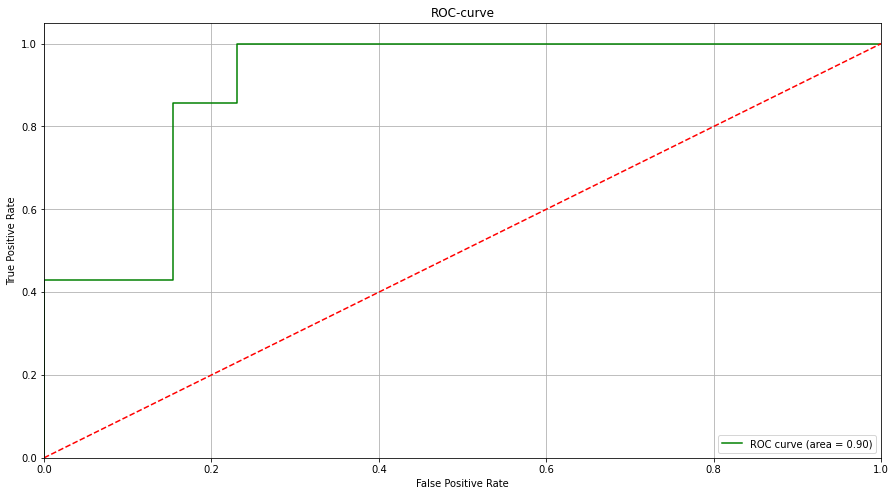

In [46]:
# get predictions
lr_probs = lr.predict_proba(X_test)
# save probabilities only for a positive outcome
lr_probs = lr_probs[:, 1]
#  ROC AUC
lr_auc = roc_auc_score(y_test, lr_probs)
print('LogisticRegression: ROC AUC=%.3f' % (lr_auc))
# build roc-curve
fpr, tpr, treshold = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)
#
#
plt.figure(figsize=(15,8))
plt.plot(fpr, tpr, color='green',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.legend(loc="lower right")
plt.grid()

### Use some polynomial feachures

c:\users\pfft\miniconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Accuracy:  0.85
Precision:  0.75
Recall:  0.8571428571428571
F1:  0.7999999999999999
Accuracy:  0.8
Precision:  0.6666666666666666
Recall:  0.8571428571428571
F1:  0.75
Accuracy:  0.65
Precision:  0.5
Recall:  0.5714285714285714
F1:  0.5333333333333333
LogisticRegression: ROC AUC=0.923
LGB: ROC AUC=0.659


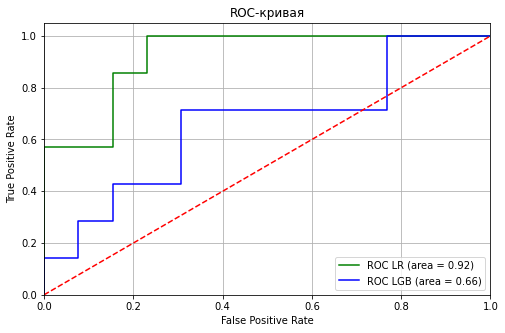

In [12]:
data = pd.read_excel(PATH+"/"+"SLE_transfor.xlsx")
data = data.drop(["Unnamed: 0", "Sample_id"], axis=1)
#
#data_health = data.query('Phenotype == "HC"')
data = data.query('Phenotype == "SLE-P" | Phenotype == "SLE-NP"')
#
X = data.drop("Phenotype", axis=1)
y = data["Phenotype"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, stratify=y, train_size=0.75)
# sign fech

stdscl = StandardScaler()
X_train = stdscl.fit_transform(X_train)
X_test = stdscl.transform(X_test)
y_train = list(map(lambda x: 1 if x == 'SLE-P' else 0, y_train.values))
y_test = list(map(lambda x: 1 if x == 'SLE-P' else 0, y_test.values))
#

import joblib
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# LOAD OUR BEST MODEL

lin_reg = joblib.load("best_model_all_fech_lr_2.pkl")
#

y_pred = lin_reg.predict(X_test)
get_metrics(y_test, y_pred) # METRICS OF BEST MODEL
#
importance = lin_reg.coef_[0] #  GET IMPORTANCES FOR FEACHURES 
#
# CHOOOSE 40 METABOLITES
# some tries after: 40 metabolites is the best choose
sign_matabolites = list(map(lambda x: x[-1], 
                            sorted(zip(abs(importance), X.columns), reverse=True)[:40]))
#
# Choose sign metabolites
X = data.drop("Phenotype", axis=1)
y = data["Phenotype"]
X = X[sign_matabolites] # 
#
# Make polynomial feachures
for met in sign_matabolites:
    X[met+'_2'] = X[met]**2
    X[met+'_3'] = X[met]**3
#
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, stratify=y, train_size=0.75)
#
stdscl = StandardScaler()
X_train = stdscl.fit_transform(X_train)
X_test = stdscl.transform(X_test)
y_train = list(map(lambda x: 1 if x == 'SLE-P' else 0, y_train.values))
y_test = list(map(lambda x: 1 if x == 'SLE-P' else 0, y_test.values))
#
# Simple logistic regression is the best model
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
get_metrics(y_test, y_pred)
#
#
model = lightgbm.LGBMClassifier(reg_alpha=1.2, 
                                num_leaves=10, 
                                n_estimators=700, 
                                max_depth=5, 
                                learning_rate=0.1, 
                                colsample_bytree=0.7,
                                random_state=SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
get_metrics(y_test, y_pred)
#
#
# ROC-curves for two models
# 

lr_probs =  lr.predict_proba(X_test)
m_probs = model.predict_proba(X_test)
# 
lr_probs = lr_probs[:, 1]
m_probs = m_probs[:,1]
# 
lr_auc = roc_auc_score(y_test, lr_probs)
md_auc = roc_auc_score(y_test, m_probs)
print('LogisticRegression: ROC AUC=%.3f' % (lr_auc))
print('LGB: ROC AUC=%.3f' % (md_auc))
# 
fpr, tpr, treshold = roc_curve(y_test, lr_probs)
fpr_1, tpr_1, treshold_1 = roc_curve(y_test, m_probs)
roc_auc = auc(fpr, tpr)
roc_auc_1 = auc(fpr_1, tpr_1)
#
plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, color='green',
         label='ROC LR (area = %0.2f)' % roc_auc)
plt.plot(fpr_1, tpr_1, color='blue',
         label='ROC LGB (area = %0.2f)' % roc_auc_1)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()

### Create ensamble model

In [15]:
# Load the models
model_1 = joblib.load("best_model_all_fech_lr_1.pkl")
model_2 = joblib.load("best_model_all_fech_lr_2.pkl")

In [19]:
pd.DataFrame({"Model_1": model_1.predict(X_test),
             "Model_2": model_2.predict(X_test),
             "y_test": y_test})

Model_1  Model_2  y_test
0         1        0       0
1         1        1       1
2         0        0       0
3         0        0       0
4         0        0       0
5         1        1       1
6         1        0       0
7         1        1       0
8         1        1       1
9         1        1       1
10        0        0       0
11        0        0       0
12        1        1       1
13        1        1       1
14        0        0       0
15        0        0       0
16        0        0       0
17        0        0       0
18        1        1       0
19        1        0       1